In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch

# Classification Problem

In [2]:
import sklearn

In [3]:
from sklearn.datasets import make_circles

In [4]:
n_samples = 1000

X,y = make_circles(n_samples,
                  noise=0.03,
                  random_state=42)

In [5]:
len(X), len(y)

(1000, 1000)

In [6]:
import pandas as pd
circles = pd.DataFrame({"X1" : X[:,0],
                        "X2" : X[:,1],
                       "label" : y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


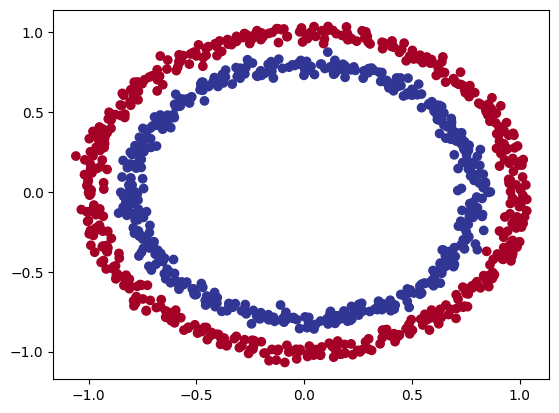

In [7]:
plt.scatter(x=X[:,0],
           y=X[:,1],
           c=y,
           cmap=plt.cm.RdYlBu)
plt.show()

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [10]:
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X:{X_sample} and for y:{y_sample}")
print(f"Shapes for one sample of X:{X_sample.shape} and for y:{y_sample.shape}")

Values for one sample of X:[0.75424625 0.23148074] and for y:1
Shapes for one sample of X:(2,) and for y:()


## Turning dataset into tensors and create train and test split

In [11]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [12]:
X = torch.from_numpy(X).type(torch.float)

In [13]:
y = torch.from_numpy(y).type(torch.float)

In [14]:
type(X), type(y)

(torch.Tensor, torch.Tensor)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42)

In [16]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Device agnotic code -> Building the model

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [18]:
from torch import nn

In [19]:
!nvidia-smi

Sun Jul 20 10:26:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             26W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [20]:
class CircleModelV0(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features = 2,
                               out_features = 5)
        self.layer2 = nn.Linear(in_features = 5,
                               out_features = 1)

    def forward(self,x):
        return self.layer2(self.layer1(x))

model_0 = CircleModelV0().to(device)
model_0    

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [22]:
#now, using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [23]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4594, -0.4413],
                      [-0.3440, -0.4129],
                      [-0.2626, -0.0177],
                      [ 0.6572,  0.4772],
                      [ 0.6416,  0.0198]], device='cuda:0')),
             ('0.bias',
              tensor([-0.4520, -0.6930,  0.0412, -0.0792,  0.4059], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.4190, -0.1889,  0.2087,  0.3608,  0.1488]], device='cuda:0')),
             ('1.bias', tensor([0.0946], device='cuda:0'))])

In [24]:
#Experimenting, with predictions with untrained model

with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions
tensor([[-0.],
        [0.],
        [-0.],
        [-0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [-0.],
        [0.]], device='cuda:0')

First 10 labels
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [25]:
#loss funcion
loss_func = nn.BCEWithLogitsLoss() #built in sigmoid activation function
#nn.BCE required a sigmoid layer before

#optimizer
optimizer = torch.optim.SGD(lr = 0.01,
                           params = model_0.parameters())

In [26]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

# Train the model

Our model is going to output **logits**.

#### `logits->prediction probabilites -> prediction labels.`

We convert logits into prediction probabilites by using activation function like sigmoid for binary claiification and softmax for multiclass classification.

We then convert it to prediction labels using `rounding` or `argmax()`.


In [27]:
#first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0802],
        [ 0.1467],
        [-0.3199],
        [-0.0138],
        [ 0.2440]], device='cuda:0')

In [28]:
y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob

tensor([[0.4800],
        [0.5366],
        [0.4207],
        [0.4966],
        [0.5607]], device='cuda:0')

In [29]:
y_preds = torch.round(y_pred_prob).squeeze()
y_preds

tensor([0., 1., 0., 0., 1.], device='cuda:0')

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, X_test = X_train.to(device), X_test.to(device) 
y_train, y_test = y_train.to(device), y_test.to(device) 

for epoch in range(epochs):
    model_0.train()

    #forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) #logits->pred prob->pred labels

    #calculate loss/accuracy
    loss = loss_func(y_logits,
                  y_train)
    acc = accuracy(y_true=y_train,
                  y_pred=y_pred)

    optimizer.zero_grad()

    # Backpropogation
    loss.backward()

    #Gradient descent
    optimizer.step()

    ## Testing
    model_0.eval()
    with torch.inference_mode():
        #forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        #calculate test loss/accuracy
        test_loss = loss_func(test_logits,
                             y_test)
        test_acc = accuracy(y_true = y_test,
                           y_pred = test_pred)

    if epoch%10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
    
    

Epoch: 0 | Loss: 0.70701, Acc: 50.88% | Test Loss: 0.71550, Test acc: 49.50%
Epoch: 10 | Loss: 0.70647, Acc: 51.00% | Test Loss: 0.71477, Test acc: 49.50%
Epoch: 20 | Loss: 0.70596, Acc: 51.12% | Test Loss: 0.71409, Test acc: 49.50%
Epoch: 30 | Loss: 0.70547, Acc: 51.12% | Test Loss: 0.71344, Test acc: 49.00%
Epoch: 40 | Loss: 0.70502, Acc: 50.75% | Test Loss: 0.71282, Test acc: 49.00%
Epoch: 50 | Loss: 0.70458, Acc: 50.75% | Test Loss: 0.71222, Test acc: 49.00%
Epoch: 60 | Loss: 0.70417, Acc: 50.75% | Test Loss: 0.71166, Test acc: 49.00%
Epoch: 70 | Loss: 0.70378, Acc: 50.75% | Test Loss: 0.71112, Test acc: 49.00%
Epoch: 80 | Loss: 0.70341, Acc: 51.00% | Test Loss: 0.71061, Test acc: 49.00%
Epoch: 90 | Loss: 0.70305, Acc: 51.12% | Test Loss: 0.71012, Test acc: 49.00%


In [31]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


Download helper_functions.py


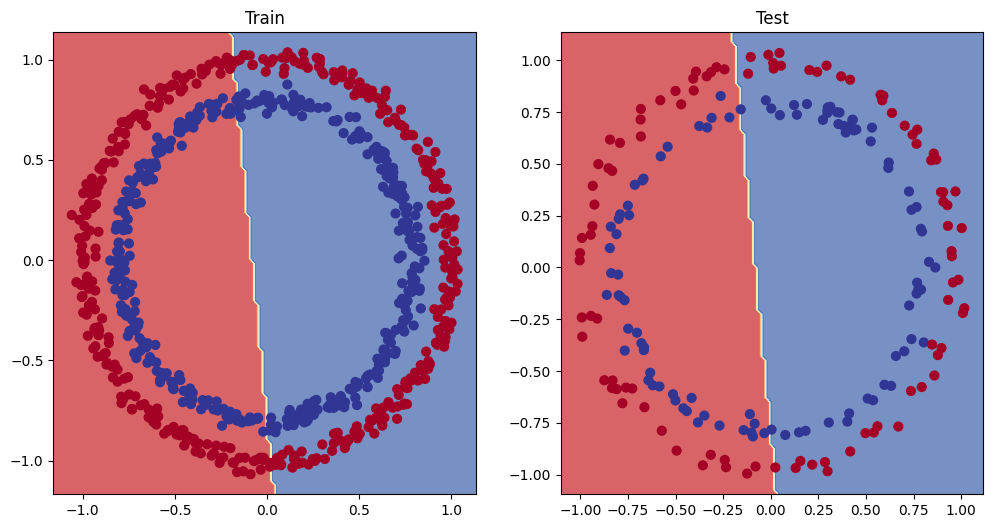

In [32]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Improving the model:

* Add more layers - give the model more chances to learn about the patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These are from model perspective as they deal directly with the model rather than the data. These values we change hence, we call them **hyperparameters**

Let us try improving our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 3 -> 4
* Increase the number of epochs: 100 -> 100

In [33]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features = 2, out_features = 10),
            nn.Linear(in_features = 10, out_features = 10),
            nn.Linear(in_features = 10, out_features = 1)
        )

    def forward(self, x):
        return self.model(x)


model_1 = CircleModelV1().to(device)
model_1


CircleModelV1(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [34]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(),
                           lr = 0.1)

In [35]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, 
                   y_train)
    acc = accuracy(y_train, y_pred)

    #optimizer zero grad
    optimizer.zero_grad()

    #backpropogation
    loss.backward()

    #updating weights
    optimizer.step()


    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                           y_test)
        test_acc = accuracy(y_test,
                           test_pred)

    if epoch%10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
    

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test Loss: 0.69261, Test acc: 51.00%
Epoch: 10 | Loss: 0.69369, Accuracy: 50.25% | Test Loss: 0.69270, Test acc: 50.00%
Epoch: 20 | Loss: 0.69351, Accuracy: 50.12% | Test Loss: 0.69283, Test acc: 49.50%
Epoch: 30 | Loss: 0.69339, Accuracy: 50.50% | Test Loss: 0.69297, Test acc: 48.00%
Epoch: 40 | Loss: 0.69329, Accuracy: 50.38% | Test Loss: 0.69310, Test acc: 49.00%
Epoch: 50 | Loss: 0.69322, Accuracy: 49.88% | Test Loss: 0.69324, Test acc: 50.00%
Epoch: 60 | Loss: 0.69317, Accuracy: 49.38% | Test Loss: 0.69336, Test acc: 51.50%
Epoch: 70 | Loss: 0.69312, Accuracy: 49.38% | Test Loss: 0.69348, Test acc: 50.50%
Epoch: 80 | Loss: 0.69309, Accuracy: 50.12% | Test Loss: 0.69359, Test acc: 50.00%
Epoch: 90 | Loss: 0.69307, Accuracy: 50.50% | Test Loss: 0.69370, Test acc: 48.50%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test Loss: 0.69379, Test acc: 48.00%
Epoch: 110 | Loss: 0.69303, Accuracy: 50.88% | Test Loss: 0.69388, Test acc: 46.50%
Epo

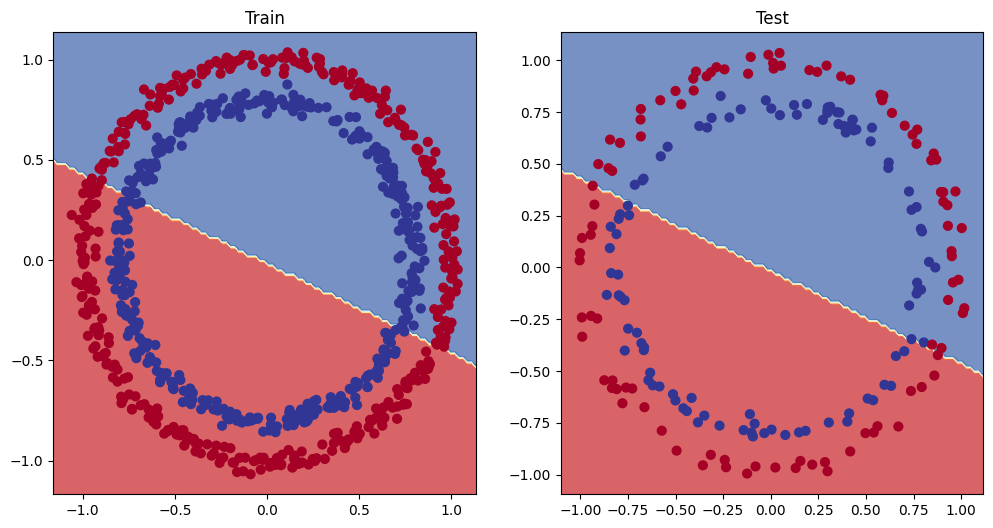

In [36]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

# The missing piece : Non-linearity

In [37]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features = 2, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features = 10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features =10, out_features = 1),
        )

    def forward(self, x):
        return self.model(x)

model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [38]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_2.parameters(),
                           lr=0.1)

In [39]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    model_2.train()

    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_train, y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(y_test, test_pred)

    if epoch%10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
    

    

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test acc: 50.00%
Epoch: 10 | Loss: 0.69248, Accuracy: 50.50% | Test Loss: 0.69260, Test acc: 50.00%
Epoch: 20 | Loss: 0.69225, Accuracy: 59.13% | Test Loss: 0.69231, Test acc: 56.50%
Epoch: 30 | Loss: 0.69209, Accuracy: 70.25% | Test Loss: 0.69212, Test acc: 68.00%
Epoch: 40 | Loss: 0.69195, Accuracy: 68.38% | Test Loss: 0.69195, Test acc: 71.00%
Epoch: 50 | Loss: 0.69181, Accuracy: 58.25% | Test Loss: 0.69177, Test acc: 58.00%
Epoch: 60 | Loss: 0.69168, Accuracy: 54.00% | Test Loss: 0.69161, Test acc: 54.50%
Epoch: 70 | Loss: 0.69155, Accuracy: 53.12% | Test Loss: 0.69146, Test acc: 53.00%
Epoch: 80 | Loss: 0.69141, Accuracy: 52.62% | Test Loss: 0.69132, Test acc: 53.00%
Epoch: 90 | Loss: 0.69128, Accuracy: 52.75% | Test Loss: 0.69117, Test acc: 53.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test acc: 52.50%
Epoch: 110 | Loss: 0.69103, Accuracy: 52.88% | Test Loss: 0.69088, Test acc: 53.50%
Epo

## Evaluating the model trained with non linear activation functions

In [40]:
model_2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(X_test).squeeze()))
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

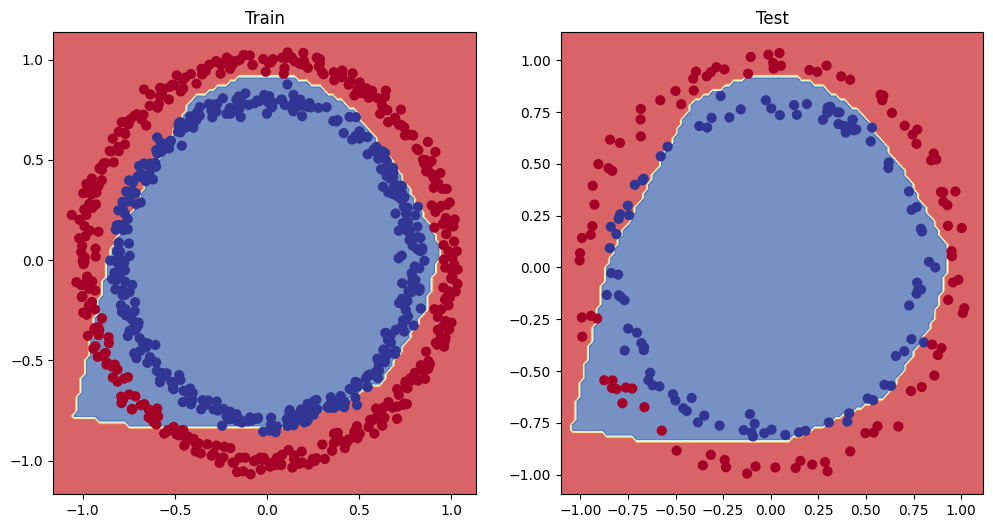

In [41]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

## Replicating non-linear activation functions

In [42]:
A = torch.arange(-10,10,1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

In [43]:
A.dtype

torch.float32

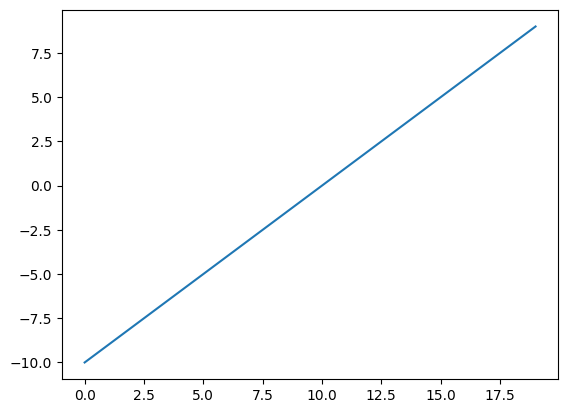

In [44]:
plt.plot(A)

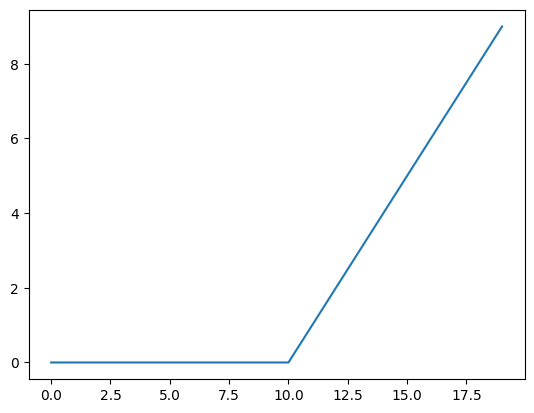

In [45]:
plt.plot(torch.relu(A))

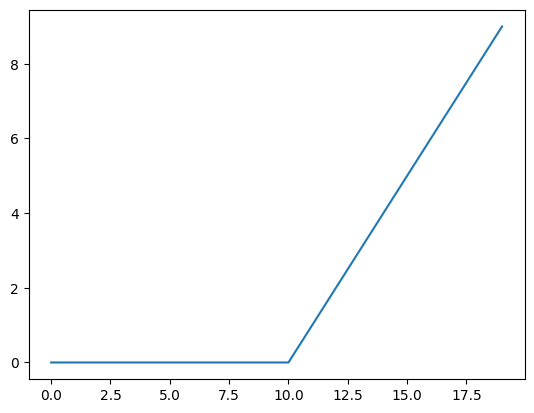

In [46]:
def relu(x:torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)

plt.plot(relu(A))

## Putting it all together using multiclass classification.

In [47]:
from sklearn.datasets import make_blobs

In [48]:
NUM_CLASSES=4
NUM_FEATURES=4
RANDOM_SEED=42

In [49]:
X_blob, y_blob = make_blobs(n_samples=1000,
                           n_features=NUM_FEATURES,
                           centers=NUM_CLASSES,
                           cluster_std=1.5,
                           random_state=RANDOM_SEED)

In [50]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

In [51]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, 
                                                                       y_blob,
                                                                       test_size=0.2,
                                                                       random_state=RANDOM_SEED)

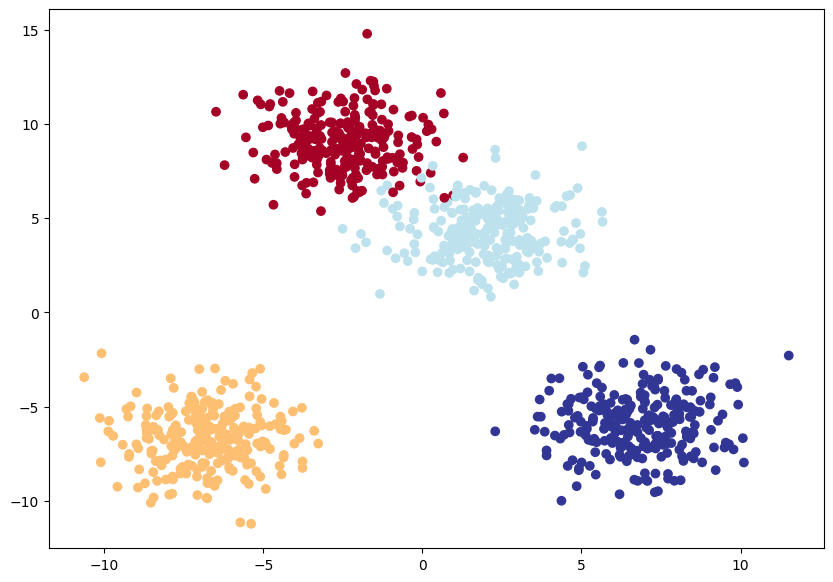

In [52]:
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

In [53]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features =input_features,
                     out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features =hidden_units,
                     out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features =hidden_units,
                     out_features=output_features)
        )

    def forward(self, x):
        return self.model(x)

model_3 = BlobModel(input_features=4, output_features=4, hidden_units=8).to(device)
model_3


BlobModel(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [54]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                     lr=0.1)

In [55]:
model_3.eval()
with torch.inference_mode():
    y_logits = model_3(X_blob_test.to(device))
y_logits[:10]

tensor([[-0.4081, -0.4554, -0.1820, -0.0294],
        [-0.6609, -0.8283, -0.2654,  0.0315],
        [-0.2771, -0.4618,  0.0150, -0.2426],
        [-0.6994, -0.2902, -0.0711,  0.3763],
        [-0.6316, -0.2298, -0.0207,  0.2131],
        [-0.0327, -0.0326,  0.6654, -0.1179],
        [-0.6952, -0.9442, -0.3544, -0.1325],
        [-0.2225, -0.2036,  0.0546,  0.0720],
        [-0.6706, -0.3236, -0.0895,  0.4435],
        [-0.7096, -0.3241, -0.0874,  0.3636]], device='cuda:0')

In [56]:
y_blob_test[:10]

tensor([0, 2, 0, 1, 1, 3, 2, 0, 1, 1])

In [57]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.4081, -0.4554, -0.1820, -0.0294],
        [-0.6609, -0.8283, -0.2654,  0.0315],
        [-0.2771, -0.4618,  0.0150, -0.2426],
        [-0.6994, -0.2902, -0.0711,  0.3763],
        [-0.6316, -0.2298, -0.0207,  0.2131]], device='cuda:0')
tensor([[0.2142, 0.2043, 0.2686, 0.3129],
        [0.1876, 0.1587, 0.2787, 0.3750],
        [0.2378, 0.1977, 0.3184, 0.2461],
        [0.1368, 0.2059, 0.2564, 0.4010],
        [0.1501, 0.2243, 0.2764, 0.3492]], device='cuda:0')


In [58]:
torch.argmax(y_pred_probs, axis=1)

tensor([3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 2, 3, 2, 3, 3, 3, 3, 2,
        3, 3, 2, 3, 3, 3, 2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 2, 2, 3, 3, 3,
        2, 3, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 2, 3, 2, 3, 2, 2, 2, 2, 3,
        3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 3, 3, 2, 3, 3, 2, 2, 2, 3,
        2, 3, 2, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2,
        2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 2, 3, 2, 3, 2,
        2, 2, 2, 3, 3, 2, 2, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 2, 2, 2,
        3, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 3, 3, 2, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2,
        3, 3, 2, 2, 3, 3, 2, 3], device='cuda:0')

In [59]:
X_blob_train = X_blob_train.to(device)
X_blob_test = X_blob_test.to(device)
y_blob_train = y_blob_train.to(device)
y_blob_test = y_blob_test.to(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

for epoch in range(epochs):
    model_3.train()

    y_logits = model_3(X_blob_train.to(device))
    y_preds = torch.argmax(torch.softmax(y_logits.to(device), dim=1), axis=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy(y_blob_train, y_preds)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        y_test_logits = model_3(X_blob_test)
        y_test_preds = torch.argmax(torch.softmax(y_test_logits, dim=1), axis=1)

        test_loss = loss_fn(y_test_logits, y_blob_test)
        test_acc = accuracy(y_blob_test, y_test_preds)

    if epoch%10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.54937, Accuracy: 0.38% | Test Loss: 1.27808, Test acc: 28.50%
Epoch: 10 | Loss: 0.54835, Accuracy: 97.25% | Test Loss: 0.46770, Test acc: 99.00%
Epoch: 20 | Loss: 0.10609, Accuracy: 100.00% | Test Loss: 0.08655, Test acc: 100.00%
Epoch: 30 | Loss: 0.03587, Accuracy: 100.00% | Test Loss: 0.03140, Test acc: 100.00%
Epoch: 40 | Loss: 0.01976, Accuracy: 100.00% | Test Loss: 0.01762, Test acc: 100.00%
Epoch: 50 | Loss: 0.01318, Accuracy: 100.00% | Test Loss: 0.01182, Test acc: 100.00%
Epoch: 60 | Loss: 0.00971, Accuracy: 100.00% | Test Loss: 0.00872, Test acc: 100.00%
Epoch: 70 | Loss: 0.00760, Accuracy: 100.00% | Test Loss: 0.00682, Test acc: 100.00%
Epoch: 80 | Loss: 0.00620, Accuracy: 100.00% | Test Loss: 0.00555, Test acc: 100.00%
Epoch: 90 | Loss: 0.00521, Accuracy: 100.00% | Test Loss: 0.00465, Test acc: 100.00%
